In [1]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt
import numpy as np

from utils import explain

today = dt.datetime.strftime(dt.datetime.today().date(), '%b %d, %Y')


 ----- HELPER MODULE IMPORTED ------

    For information on the helper module:
        run 'help(explain)' in any cell. 
        
    To directly use:
        run 'explain.what_is()' with no parameters.
    


#### Create Dataframes

In [2]:
files = sorted(['data/' + _ for _ in os.listdir('data/') if '.txt' not in _])

In [3]:
bus_char_df = pd.read_csv(files[0])
bus_own_df = pd.read_csv(files[1])
bus_tech_df = pd.read_csv(files[2])
comp_sum_df = pd.read_csv(files[3])
slbo = pd.read_csv(files[4])

state_code_path = 'https://raw.githubusercontent.com/jedc4xer/abs_group_assessment/main/data/state_codes.csv'
state_codes = pd.read_csv(state_code_path)


In [8]:
def clean_for_map(df, target = 'industry'):
    if target not in ['gender','race_group_label','industry']:
        possible = ", ".join(['gender','race_group_label','industry'])
        print(f'You must choose one of: {possible}')
        return
    label = {'gender': 'Owner Gender','race_group_label': 'Owner Race','industry':'Industry'}[target]
    
    subset = df[(df.payann != 0) & (df.gender != 'Total') & (df.race_group_label != 'Total') & (df.industry_code != '00')]
    subset = subset[['name','geo_id',target,'payann','firmpdemp','emp']]
    subset['payann'] = subset['payann'] * 1000
    subset['avg_pay'] = subset.apply(lambda row: row.payann/row.emp, axis = 1)

    subset_agg = subset.groupby(
        by = ['name']
            )[['avg_pay']].agg(max_pay = ('avg_pay','max'))

    subset_agg.reset_index(inplace = True)

    grouped = pd.merge(subset, subset_agg, left_on = 'name', right_on = 'name', how = 'left')
    
    grouped = grouped[(grouped.avg_pay == grouped.max_pay)].reset_index(drop = True)
    grouped = grouped.sort_values(by = 'name').reset_index(drop = True)
    grouped = grouped.drop_duplicates().reset_index(drop = True)

    grouped = pd.merge(grouped,state_codes, left_on = 'name', right_on = 'State', how = 'left')

    grouped = grouped[['name',target,'avg_pay','Postal Abbr.']]

    diffs = set(subset_agg.name.tolist()) - set(grouped.name.tolist())
    if len(diffs) > 0:
        print('There are some states missing.')
    return grouped, target, label

def plot_maps(grouped, target):
    grouped, target, label = clean_for_map(grouped, target)
    
    if target == 'gender':
        color_scheme = px.colors.qualitative.Plotly[2:]
    else:
        color_scheme = px.colors.qualitative.Bold
        
    customdata = np.stack((grouped['name'],grouped[target]),axis = -1)
    
    mapfig = px.choropleth(grouped, 
                           title = f'Highest Average Pay based on {label}',
                           locations = 'Postal Abbr.',
                           locationmode = "USA-states",
                           scope = 'usa',
                           color = target,
                           hover_data = ['name',target,'avg_pay'],
                           color_discrete_sequence = color_scheme,
                           height = 600,
                           width = 1300,
                           )

    mapfig.add_annotation(
        text = (f"Created by: Jed Dryer<br>{today}<br>Source: US Census - 2019 ABS"),
        showarrow=False,
        x = .54,
        y = .01,
        xref='paper',
        yref='paper' ,
        xanchor='left',
        yanchor='bottom',
        xshift=-1,
        yshift=-3,
        font=dict(size=10, color="grey"),
        align="right",
        )

    mapfig.update_layout(margin={"r":3,"t":30,"l":0,"b":10}, dragmode = False)
    mapfig.update_layout(title_y = 0.95, title_x = 0.25, title_font_size = 18,
                        legend = dict(x=0.9,y=0.6))
    mapfig.update_traces(hovertemplate = '<b>State: %{customdata[0]}</b><br>Value: %{customdata[1]}')
    mapfig.update_geos(resolution=50,showlakes=True, lakecolor="Lightblue", subunitcolor = 'black')
    #save_label = "".join(_.lower() for _ in label if _.isalpha())
    #mapfig.write_html(f'highest_avg_pay_{save_label}.html')
    #mapfig.show()
    return mapfig

reasons = ['gender','race_group_label','industry']
maps = []
for reason in reasons:
    maps.append(plot_maps(comp_sum_df, reason))
    
with open('company_pay_maps.html', 'w') as mapfile:
    for fig in maps:
        mapfile.write(fig.to_html(full_html = False, include_plotlyjs='cdn'))
    mapfile.close()


In [556]:
reason_owned = bus_own_df[
    (bus_own_df['qdesc_label'] == 'REASONOWN') &
    (~bus_own_df['industry'].str.contains('Total')) &
    (~bus_own_df['gender'].str.contains('All')) &
    (bus_own_df['ownchar_label'].str.contains(':'))]

reason_owned[['reason','importance']] = reason_owned.apply(
    lambda row: row['ownchar_label'].split(":"), axis = 1, result_type = 'expand'
)

reason_owned = reason_owned[['industry','gender','reason','importance','ownpdemp']]

grouped_reason = reason_owned.groupby(
    by = ['industry','reason','importance'])[['ownpdemp']].agg(
    responses = ('ownpdemp', 'sum')
)

grouped_reason['ratio'] = 100 * (grouped_reason['responses'] / grouped_reason.groupby(level = [0,1])['responses'].transform('sum'))
grouped_reason['ratio'] = grouped_reason['ratio'].round(2)
grouped_reason.reset_index(inplace = True)

accom_subset = grouped_reason[(grouped_reason['industry'].str.contains('inanc|ducati'))]
accom_subset.sort_values(by = ['importance','ratio'], ascending = False, inplace = True)
accom_subset.rename(columns = {'ratio': 'Percent of Total'}, inplace = True)
picked_industry = accom_subset['industry'].unique().tolist()

C:\Users\Work\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [557]:
reasons = grouped_reason.reason.unique().tolist()
longest_reason = max(reasons, key = len)
longest_reason = "<" + longest_reason + ">"
longest_reason = len(longest_reason)
new_reasons = {}
for reason in reasons:
    old_reason = reason
    if len(reason) != longest_reason:
        reason = " " + reason + " "
        cntr = 0
    while len(reason) < longest_reason:
        if cntr % 3 == 0:
            reason = "-" + reason + "-"
        else:
            reason = " " + reason + " "
        cntr += 1
    
    if len(reason) < 30:
        reason = reason + "-"
    reason = "<" + reason + ">"
    
    new_reasons[old_reason] = reason
    
for key in new_reasons.keys():
    print(new_reasons[key])
accom_subset['reason'] = accom_subset['reason'].apply(lambda x: new_reasons[x])

< - Balance work and family - ->
<  - Best avenue for ideas -  ->
< - Carry on family business - >
<-  - Couldn't find a job -  -->
<-  -  - Flexible hours -  -  ->
< Friend or family role model ->
<-  -  - Greater income -  -  ->
< -  - Help my community -  - ->
< -  -  -  - Other -  -  -  - ->
<  - Start my own business -  ->
< - Wanted to be my own boss - >
<-  -  - Work for self -  -  -->


C:\Users\Work\AppData\Local\Temp/ipykernel_23740/1238197172.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [592]:

fig = px.bar(accom_subset, x = 'Percent of Total', y = 'reason', color = 'importance',
            width = 1300, height = 600, orientation = 'h',
            hover_data = ['responses','Percent of Total'], text = 'Percent of Total', facet_col = 'industry',
            facet_col_spacing=0.18
        )
fig.update_layout(title = 'Reasons for Starting a Company')
fig.update_layout(yaxis_title = None)

fig.update_traces(textposition = 'inside', insidetextanchor = 'middle', textfont = {'color': 'white'})
fig.update_yaxes(side = 'right')
fig.update_xaxes(ticks = 'outside')
fig.update_layout(title_y = .98, title_x = 0.003, title_font_size = 22)
fig.update_layout(xaxis_title = "Percent of Total", uniformtext_minsize = 13,
                 uniformtext_mode = 'hide', paper_bgcolor = 'white', plot_bgcolor = 'white',
                 legend = dict(orientation = 'h', x=0,y=1.15, font = dict(size=13)))
fig.update_layout(margin={"r":0,"t":90,"l":0,"b": 90}, dragmode = False)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))

fig.add_annotation(
        text = (f"Created by: Jed Dryer | {today} | Source: US Census - 2019 ABS"),
        showarrow=False,
        x = .70,
        y = -.19,
        xref='paper',
        yref='paper' ,
        xanchor='left',
        yanchor='bottom',
        xshift=-1,
        yshift=-3,
        font=dict(size=10, color="grey"),
        align="right",
        )

fig.write_html('stacked_reasons.html')

In [ ]:
grouped_reason['ratio'] = 100 * (grouped_reason['responses'] / grouped_reason.groupby(level = [0,1])['responses'].transform('sum'))
grouped_reason['ratio'] = grouped_reason['ratio'].round(2)
grouped_reason.reset_index(inplace = True)

In [ ]:
# This analysis is assuming that the same companies that are 

In [35]:
robotics['firmpdemp']

10       53464
14         443
836      11878
1656     81173
1660       490
         ...  
40476       35
41101    94489
41121      525
42371    13603
42375       22
Name: firmpdemp, Length: 101, dtype: int64

In [91]:
tech_subset = bus_tech_df[(bus_tech_df['industry_code'] == '00') & (bus_tech_df['gender'] == 'Total') & (bus_tech_df['emp'] != 0)].drop_duplicates()
tech_subset = tech_subset[['name','emp','firmpdemp','industry','payann','techuse_label']]
tech_subset = tech_subset[(tech_subset['techuse_label'].str.contains('Did not use|High use'))]
tech_subset[['tech','usage']] = tech_subset.apply(lambda row: row['techuse_label'].split(":"), axis = 1, result_type = 'expand')

tech_subset['total_companies'] = tech_subset.groupby(by = ['name','tech'])['firmpdemp'].transform('sum')
tech_subset['use_rate'] = tech_subset['firmpdemp'] / tech_subset['total_companies']
tech_subset['average_pay'] = 1000 * (tech_subset['payann'] / tech_subset['emp'])
tech_subset.sort_values(by = ['usage', 'firmpdemp'], ascending = False, inplace = True)
tech_subset.head(2)

,name,emp,firmpdemp,industry,payann,techuse_label,tech,usage,total_companies,use_rate,average_pay
3380,California,2947626,102413,Total for all sectors,215223062,Specialized Software: High use,Specialized Software,High use,424022,0.241528,73015.729268
3372,California,2216353,70133,Total for all sectors,185466118,Cloud-Based: High use,Cloud-Based,High use,420548,0.166766,83680.766557


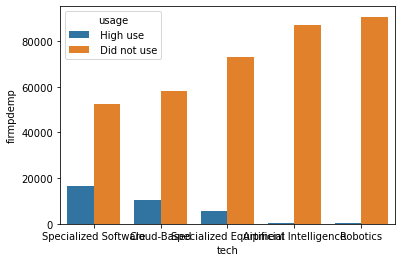

In [99]:
fig = plt.Figure(figsize = (25,10))
ax = sns.barplot(data = tech_subset, x = 'tech', y = 'firmpdemp', hue = 'usage', ci = None)

In [16]:
bus_char_df[(bus_char_df['buschar_label'].str.contains('amily'))][['name','buschar_label','emp','firmpdemp','payann']]

,name,buschar_label,emp,firmpdemp,payann
9,Mississippi,Family-owned,45125,4744,1400709
10,Mississippi,Not family-owned,86891,11756,3137602
55,Missouri,Family-owned,196071,18034,6936552
56,Missouri,Not family-owned,258777,33035,9853109
99,Montana,Family-owned,33990,6419,1063507
...,...,...,...,...,...
2170,Massachusetts,Not family-owned,324064,45981,17339401
2214,Michigan,Family-owned,303277,21353,10580415
2215,Michigan,Not family-owned,470342,60397,20233238
2259,Minnesota,Family-owned,160962,17863,6212935


In [393]:
bus_char_df.buschar_label.unique().tolist()

['All firms',
 '1 person',
 '2 to 4 people',
 '5 to 10 people',
 '11 or more people',
 'Unknown number of owners',
 'Total reporting',
 'Item not reported',
 'Family-owned',
 'Not family-owned',
 'Not applicable',
 'Jointly owned and equally operated by spouses',
 'Jointly owned but primarily operated by male spouse',
 'Jointly owned but primarily operated by female spouse',
 'Not jointly owned by spouses',
 'Other businesses, including distributors of your product(s)',
 'Federal government',
 'State and local government, including school districts, transportation authorities, etc.',
 'Other organizations',
 'Individuals',
 'Full-time paid employees',
 'Part-time paid employees',
 'Paid day laborers',
 'Temporary staffing obtained from a temporary help service',
 'Leased employees from leasing service or professional employer organization',
 'Contractors, subcontractors, independent contractors, or outside consultants',
 'None of the above',
 'Business is currently operating',
 'Busine